In [1]:
import os
import sys
import pickle
import warnings
import time
import logging
import glob


import numpy as np
import matplotlib.pyplot as plt
from iminuit import Minuit
from matplotlib import ticker
from matplotlib.legend import Legend

from utils import *
from AnalyseDefects import AnalyseDefects

plt.style.use('sg_article')


In [3]:

class AnalyseDefectsAll:
    def __init__(self, system_size_list, ):
        self.LX = system_size_list
        self.inputs_paths = [f"data\\nematic_analysis{LX}_LL0.05\\merged_results" for LX in self.LX]
        self.act_list = [list(np.load(os.path.join(path, "activity_list.npy"))) for path in self.inputs_paths]
        self.window_sizes = [list(np.load(os.path.join(path, 'window_sizes.npy'))) for path in self.inputs_paths]
        self.Nactivity = [len(act) for act in self.act_list]

        self.output_path = "data\\nematic_analysis_all"

    def get_av_defects(self, LX = 512, act_idx_bounds = None, density = True):
        """
        Returns act_list, av_defects
        """

        idx = self.LX.index(LX)
        inputs_path = self.inputs_paths[idx]

        if act_idx_bounds is None:
            act_idx_bounds = [0, None]
        else:
            act_idx_bounds[0] = self.act_list[idx].index(act_idx_bounds[0])
            act_idx_bounds[1] = self.act_list[idx].index(act_idx_bounds[1]) + 1

        act_list = list(np.load(os.path.join(inputs_path, "activity_list.npy")))[act_idx_bounds[0]:act_idx_bounds[1]]

        norm = LX**2 if density else 1

        try:
            av_defects = np.load(os.path.join(self.inputs_paths[idx], 'av_defects.npy')) / norm
        except:
            print('Average defects not found. Analyse defects first.')
            return

        return act_list, av_defects[act_idx_bounds[0]:act_idx_bounds[1]]

    def get_binder_susceptibility(self, LX = 512, act_idx_bounds = None, density = True):
        """
        Returns binder, susceptibility
        """

        idx = self.LX.index(LX)
  
        try:
            binder = np.load(os.path.join(self.inputs_paths[idx], 'binder_cumulants.npy'))
            susceptibility = np.load(os.path.join(self.inputs_paths[idx], 'susceptibility.npy'))
        except:
            print('Binder cumulants or susceptibility not found. Analyse defects first.')
            return
        return binder, susceptibility

    def get_sfac(self, LX, time_av = True, weighted = False,):
        """
        returns kbins, sfac_av, rad, pcf_av
        """

        idx = self.LX.index(LX)
        input_path = self.inputs_paths[idx]

        suffix = '' if weighted else '_unweighted'
        prefix = 'time_' if time_av else ''

        try:
            sfac_av = np.load(os.path.join(input_path, f'sfac_{prefix}av{suffix}.npy'))
            pcf_av = np.load(os.path.join(input_path, f'pcf_{prefix}av.npy'))
        except:
            print('Structure factor or pcf not found. Analyse defects first.')
            return

        rad = np.loadtxt(os.path.join(input_path, 'rad.txt'))
        kbins = np.loadtxt(os.path.join(input_path, 'kbins.txt'))
    
        return kbins, sfac_av, rad, pcf_av


    def plot_av_defects(self, fit_dict = {}, LX_list = None, act_bounds = None, \
                        plot_density = True, figsize=(7,4.5), verbose = False, ax = None,inset_box=None):
        """
        fit_dict: dictionary containing the fit parameters with keys
        'fit_func': fit function
        'fit_string': string of the fit function
        'param_guess': guess for the fit parameters
        """
 
        if fit_dict == {}:
            do_fit = False
        else:
            do_fit = True
            fit_func = fit_dict['fit_func']
            fit_string = fit_dict['fit_string']
            param_guess = fit_dict['param_guess']

        if ax is None:
            fig, ax = plt.subplots(figsize=figsize)
            return_fig = True
        else:
            return_fig = False
        axin = ax.inset_axes(inset_box) if inset_box is not None else None
        marker_shape = ['s', 'o', '^', 'v', 'D', 'P', 'X', 'h', 'd', 'p', 'H', '8', '1', '2']

        LX_list = self.LX if LX_list is None else LX_list

        for i, LX in enumerate(self.LX):
            norm = LX**2 if plot_density else 1

            try:
                av_defects = np.load(os.path.join(self.inputs_paths[i], 'av_defects.npy')) / norm
            except:
                print('Average defects not found. Analyse defects first.')
                return
   
            ax.errorbar(self.act_list[i], av_defects[:, 0], yerr = av_defects[:, 1], fmt = marker_shape[i],\
                         label = f'L = {self.LX[i]}', alpha=.6, elinewidth=1.5, capsize=1.5, capthick=1, markersize = 4, color = f'C{i}' )
            if axin is not None:
                axin.errorbar(self.act_list[i], av_defects[:, 0], yerr = av_defects[:, 1], fmt = marker_shape[i], \
                               elinewidth=1.5, capsize=1.5, alpha=.6, capthick=1, markersize = 4, color = f'C{i}')

            if do_fit:
                act_idx_bounds = [0, None]
                if act_bounds is None:
                    act_idx_bounds[0] = 0
                    act_idx_bounds[1] = None
                else:
                    act_idx_bounds[0] = self.act_list[i].index(act_bounds[0])
                    act_idx_bounds[1] = self.act_list[i].index(act_bounds[1]) + 1
     
                activities = np.array(self.act_list[i][act_idx_bounds[0]:act_idx_bounds[1]])
            
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore", category=np.VisibleDeprecationWarning)

                    fit = do_chi2_fit(fit_func, activities, av_defects[act_idx_bounds[0]:act_idx_bounds[1], 0], \
                                av_defects[act_idx_bounds[0]:act_idx_bounds[1], 1]*10, parameter_guesses = param_guess, verbose=verbose)
                    Ndof, chi2, pval = get_statistics_from_fit(fit, len(activities), subtract_1dof_for_binning = False)

                  
                    print(f'For LX = {LX}:')
                    print("Valid minimum: ", fit.fmin.is_valid)
                    print('Params: ', fit.values[:])
                    print(f'Ndof = {Ndof}, chi2 = {chi2:.3f}, pval = {pval:.3f}\n')
                    
                #  d = generate_dictionary(fit, len(activities), chi2_suffix = None)
                #  text = nice_string_output(d, extra_spacing=4, decimals=3)
                #  add_text_to_ax(0.02, 0.96, text, ax, fontsize=14)

                ax.plot(activities, fit_func(activities, *fit.values[:]), '-', color = f'C{i}', label=rf'Fit $L = {LX}$', linewidth = 2)
        
        if do_fit:
            ax.text(0.10, 0.95, rf'Fit = {fit_string}', transform=ax.transAxes, fontsize=16, verticalalignment='top', fontweight='bold')

        if return_fig:
            ax.legend(loc='lower right')
            ax.set_xlabel(r'Activity')
            ax.set_ylabel(r'Av. defect density')
            fig.tight_layout()

            if inset_box is None:
                return fig, ax
            else:
            # ax.indicate_inset_zoom(axin)
                return fig, ax, axin
        else:
            return ax if inset_box is None else ax, axin
    
    def plot_alpha_mean_single(self, use_density_fit = True, act_bounds = None, plot_sfac = True, weighted = False,\
                                breakax = True, ax = None, labels=True, inset_box = None):
        
        suffix = 'dens' if use_density_fit else 'count'
        sfac_suffix = '' if weighted else '_unweighted'

        axin = ax.inset_axes(inset_box) if inset_box is not None else None
        if ax is None:
            if breakax:
                fig, (ax, ax2) = plt.subplots(2, 1, sharex=True)
                cutoff1 = 0
                cutoff2 = -.1
            else:
                fig, ax = plt.subplots(figsize=(9, 6))
        marker_shape = ['s-', 'o-', '^-', 'v-', 'D-', 'P-', 'X-', 'h-', 'd-', 'p-', 'H-', '8-', '1-', '2-']
        marker_shape_inset = ['s-', 'o-', '^-', 'v-', 'D-']
        for i, LX in enumerate(self.LX):
            try:
                alpha_list = np.load(os.path.join(self.inputs_paths[i], f'alpha_list_{suffix}.npy'))
                alpha_list_sfac = np.load(os.path.join(self.inputs_paths[i], f'fit_params_sfac_time_av{sfac_suffix}.npy'))
            except:
                print('Alpha list not found. Analyse hyperuniformity first.')
                return
            
            act_list = self.act_list[i]

            act_idx_bounds = [0, None]
            if act_bounds is None:
                act_idx_bounds[0] = 0
                act_idx_bounds[1] = None
            else:
                act_idx_bounds[0] = act_list.index(max(act_bounds[0], act_list[0]))
                act_idx_bounds[1] = act_list.index(min(act_bounds[1], act_list[-2])) + 1
            
            act_list = np.array(act_list[act_idx_bounds[0]:act_idx_bounds[1]])
            act_list_sfac = act_list.astype(float)
          #  act_list_sfac = np.array(act_list_sfac[act_idx_bounds[0]:act_idx_bounds[1]])
            alpha_list = np.array(alpha_list[act_idx_bounds[0]:act_idx_bounds[1]])
            alpha_list_sfac = alpha_list_sfac[act_idx_bounds[0]:act_idx_bounds[1]]


            mask = (np.isnan(alpha_list_sfac[:, 0])) | (alpha_list_sfac[:,0] == 0.1)
            alpha_list_sfac = alpha_list_sfac[~mask]
            act_list_sfac = act_list_sfac[~mask]
       
       
            if breakax:
                if plot_sfac:
                    mask1 = alpha_list_sfac[:, 0] > cutoff1
                    mask2 = alpha_list_sfac[:, 0] < cutoff2
                    ax.errorbar(act_list_sfac[mask1], alpha_list_sfac[mask1, 0], alpha_list_sfac[mask1, 2], fmt = marker_shape[i], \
                                label = f'L = {self.LX[i]}', alpha = .6, elinewidth=1.5, capsize=1.5, capthick=1, markersize = 4, color = f'C{i}')
                    ax2.errorbar(act_list_sfac[mask2], alpha_list_sfac[mask2, 0], alpha_list_sfac[mask2, 2], fmt = marker_shape[i], \
                                 alpha = .6, elinewidth=1.5, capsize=1.5, capthick=1, markersize = 4, color = f'C{i}')
       
                else:
                    mask1 = alpha_list[:, 0] > cutoff1
                    mask2 = alpha_list[:, 0] < cutoff2
                    ax.errorbar(act_list[mask1], alpha_list[mask1, 0], alpha_list[mask1, 1], \
                                fmt = marker_shape[i], label = f'L = {self.LX[i]}', alpha = .6, elinewidth=1.5, capsize=1.5,lw=1, capthick=1, markersize = 4)
                    ax2.errorbar(act_list[mask2], alpha_list[mask2, 0], alpha_list[mask2, 1], \
                                    fmt = marker_shape[i], label = f'L = {self.LX[i]}', alpha = .6, elinewidth=1.5,  lw=1,capsize=1.5, capthick=1, markersize = 4)
            else:
                label = f'L = {self.LX[i]}' if labels else None
                if plot_sfac:
    
                    ax.errorbar(act_list_sfac, alpha_list_sfac[:, 0], alpha_list_sfac[:, 2], fmt = marker_shape[i], \
                                label = label, alpha = .6, elinewidth=1.5, capsize=1.5, lw=1, capthick=1, markersize = 4, color = f'C{i}')
                    if axin is not None:
                        axin.errorbar(act_list_sfac, alpha_list_sfac[:, 0], alpha_list_sfac[:, 2], fmt = marker_shape_inset[i], \
                                elinewidth=1.5, capsize=1.5, alpha=.6, capthick=1, markersize = 4, lw=1, color = f'C{i}')
         
                else:
                    ax.errorbar(act_list, alpha_list[:, 0], alpha_list[:, 1], fmt = marker_shape[i], label = label,\
                             alpha = .6, elinewidth=1.5, capsize=1.5, capthick=1, markersize = 4, lw=1)
                    if axin is not None:
                        axin.errorbar(act_list, alpha_list[:, 0], alpha_list[:, 1], fmt = marker_shape_inset[i], label = f'L = {self.LX[i]}',\
                                       alpha = .6, elinewidth=1.5, capsize=1.5, capthick=1, markersize = 4, lw=1)
                        axin.errorbar(act_list[:5], alpha_list[:5, 0], alpha_list[:5, 1], fmt = marker_shape_inset[i], \
                                    alpha = .6, elinewidth=1.5, capsize=1.5, capthick=1, markersize = 4, lw=1)
                        

        if ax is None:
            if breakax:
                ax2.set_ylim(-.6, cutoff2)
                ax.set_ylim(cutoff1, .5)
                
                ax.legend()
                fig.supxlabel(r'$\zeta$')
            #  fig.supylabel(rf'$\langle\alpha \rangle$')
                ax.set_title(rf'Time av. of $\alpha $ vs activity')
        
                ax.spines.bottom.set_visible(False)
                ax2.spines.top.set_visible(False)
                ax.xaxis.tick_top()
                ax.tick_params(labeltop=False)  # don't put tick labels at the top
                ax2.xaxis.tick_bottom()

                ax2.set_yticks([cutoff2, cutoff2 - .2, cutoff2 - .4], [cutoff2, cutoff2 - .2, cutoff2 - .4])

                d = .5  # proportion of vertical to horizontal extent of the slanted line
                kwargs = dict(marker=[(-1, -d), (1, d)], markersize=8,
                            linestyle="none", color='k', mec='k', mew=1, clip_on=False)
                ax.plot([0, 1], [0, 0], transform=ax.transAxes, **kwargs)
                ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)

                fig.tight_layout()
                return fig, ax, ax2
            else:
                ax.legend()
                ax.set_xlabel(r'$\zeta$')
                ax.set_ylabel(rf'$\langle\alpha \rangle$')
                ax.set_title(rf'Time av. of $\alpha $ vs activity')

                fig.tight_layout()
                return fig, ax
        return ax if axin is None else ax, axin


    def plot_alpha_mean(self, use_density_fit = True, include_fluc=False, weighted = False, include_time_av = False, act_bounds = None,):
        

        suffix = 'dens' if use_density_fit else 'count'
        sfac_suffix = '' if weighted else '_unweighted' 
     
        fig, ax = plt.subplots(figsize=(9, 6))
        marker_shape = ['s-', 'o-', '^-', 'v-', 'D-', 'P-', 'X-', 'h-', 'd-', 'p-', 'H-', '8-', '1-', '2-']

        for i, LX in enumerate(self.LX):
            act_list = self.act_list[i]
            if include_fluc:
                try:
                    alpha_list = np.load(os.path.join(self.inputs_paths[i], f'alpha_list_{suffix}.npy'))
                  #  act_list = list(np.load(os.path.join(self.inputs_paths[i], f'act_list_alpha_fit.npy')))
                except:
                    print('Alpha list not found. Analyse hyperuniformity first.')
                    return
            try:
                alpha_list_sfac = np.load(os.path.join(self.inputs_paths[i], f'alpha_list_sfac{sfac_suffix}.npy'))
                if include_time_av:
                    alpha_list_sfac_time_av = np.load(os.path.join(self.inputs_paths[i], f'fit_params_sfac_time_av{sfac_suffix}.npy'))[:,[0,2]]
            except:
                print('Alpha list not found. Analyse sfac first.')
                return

            act_idx_bounds = [0, None]
            if act_bounds is None:
                act_idx_bounds[0] = 0
                act_idx_bounds[1] = None
            else:
                act_idx_bounds[0] = act_list.index(max(act_bounds[0], act_list[0]))
                act_idx_bounds[1] = act_list.index(min(act_bounds[1], act_list[-2])) + 1
                
            act_list = act_list[act_idx_bounds[0]:act_idx_bounds[1]]
            alpha_list_sfac = alpha_list_sfac[act_idx_bounds[0]:act_idx_bounds[1]]

            if include_fluc:
                alpha_list = alpha_list[act_idx_bounds[0]:act_idx_bounds[1]]
                ax.errorbar(act_list, alpha_list[:, 0], alpha_list[:, 1], fmt = marker_shape[0], \
                        label = f'L = {self.LX[i]}', alpha = .6, elinewidth=1.5, capsize=1.5, capthick=1, markersize = 4, color = f'C{i}')
            if include_time_av:
                alpha_list_sfac_time_av = alpha_list_sfac_time_av[act_idx_bounds[0]:act_idx_bounds[1]]
                ax.errorbar(act_list, alpha_list_sfac_time_av[:, 0], alpha_list_sfac_time_av[:, 1], fmt = marker_shape[2], \
                                alpha = .6, elinewidth=1.5, capsize=1.5, capthick=1, markersize = 4, color = f'C{i}')
            
            ax.errorbar(act_list, alpha_list_sfac[:, 0], alpha_list_sfac[:, 1], fmt = marker_shape[1], \
                            alpha = .6, elinewidth=1.5, capsize=1.5, capthick=1, markersize = 4, color = f'C{i}', label = f'L = {self.LX[i]}')
               

        ax.legend()
        ax.set_xlabel(r'$\zeta$')
        ax.set_ylabel(rf'$\langle\alpha \rangle$')
        ax.set_title(rf'Time av. of $\alpha $ vs activity')

        fig.tight_layout()
        return fig, ax


    def plot_alpha_mean_v2(self, Ndataset = 0, use_density_fit = True, include = ['all'], use_merged = False, save = False, fig_name = None):
        
        """
        include can take values
        'all': include all fits
        'fluc': include only fits based on fluctuations
        'sfac_all': include all fits with structure factor
        'sfac_time_av': include only fits with time averaged structure factor (fit of time av)
        'sfac_av': include only fits with spatially averaged structure factor   (time av of fits)
        'sfac_time_av_unweighted': include only fits with time averaged structure factor, unweighted  (fit of time av)
        'sfac_av_unweighted': include only fits with spatially averaged structure factor, unweighted (time av of fits)
        """

        suffix = 'dens' if use_density_fit else 'count'
        output_path, Ndataset = self.__get_outpath_path(Ndataset, use_merged)
        act_list = self.act_list[Ndataset]

        fluc_path = os.path.join(output_path, f'alpha_list_{suffix}.npy')
        sfac_path = os.path.join(output_path, f'alpha_list_sfac.npy')
        sfac_time_av_path = os.path.join(output_path, f'fit_params_sfac_time_av.npy')
        sfac_unweighted_path = os.path.join(output_path, f'alpha_list_sfac_unweighted.npy')
        sfac_time_av_unweighted_path = os.path.join(output_path, f'fit_params_sfac_time_av_unweighted.npy')

        file_name_list = []
        act_list_to_use = []
        label_list = []

        if 'all' in include:
            file_name_list = [fluc_path, sfac_path, sfac_time_av_path, sfac_unweighted_path, sfac_time_av_unweighted_path]
            act_list_to_use = [0, 1, 1, 1, 1]
            label_list = [r'$\overline{\delta \rho ^2}$ (time av. of fits)', rf'$S_W(k)$ (time av. of fits)', rf'$S_W(k)$ (fit of time av.)', rf'$S_U(k)$ (time av. of fits)', rf'$S_U(k)$ (fit of time av.)']
        else:
            for val in include:
                if val == 'fluc':
                    file_name_list.append(fluc_path)
                    act_list_to_use.append(0)
                    label_list.append(r'$\overline{\delta \rho ^2}$ (time av. of fits)')
                elif val == 'sfac_all':
                    file_name_list.extend([sfac_path, sfac_time_av_path, sfac_unweighted_path, sfac_time_av_unweighted_path])
                    act_list_to_use.extend([1, 1, 1, 1])
                    label_list.extend([rf'$S_W(k)$ (time av. of fits)', rf'$S_W(k)$ (fit of time av.)', rf'$S_U(k)$ (time av. of fits)', rf'$S_U(k)$ (fit of time av.)'])
                elif val == 'sfac_av':
                    file_name_list.append(sfac_path)
                    act_list_to_use.append(1)
                    label_list.append(rf'$S_W(k)$ (time av. of fits)')
                elif val == 'sfac_time_av':
                    file_name_list.append(sfac_time_av_path)
                    act_list_to_use.append(1)
                    label_list.append(rf'$S_W(k)$ (fit of time av.)')
                elif val == 'sfac_av_unweighted':
                    file_name_list.append(sfac_unweighted_path)
                    act_list_to_use.append(1)
                    label_list.append(rf'$S_U(k)$ (time av. of fits)')
                elif val == 'sfac_time_av_unweighted':
                    file_name_list.append(sfac_time_av_unweighted_path)
                    act_list_to_use.append(1)
                    label_list.append(rf'$S_U(k)$ (fit of time av.)')
                else:
                    print(f'Unknown option {val}.')
                    return

        fig, ax = plt.subplots(figsize=(9, 6))

        for i, file_name in enumerate(file_name_list):
            try:
                alpha_list = np.load(file_name)
            except:
                print(f'File {file_name} not found.')
                continue

            # act_list = act_list_fluc if act_list_to_use[i] == 0 else act_list_sfac
            alpha_std = alpha_list[:, 1] if alpha_list.shape[1] == 2 else alpha_list[:, 2]

            ax.errorbar(act_list, alpha_list[:, 0], alpha_std, fmt = '.-', capsize=2, label = label_list[i], \
                        capthick=1, elinewidth=1, markeredgewidth=2, alpha = 0.5, markersize=4,)

        ax.legend(ncol=2, fontsize=12)
        ax.set_xlabel(r'Activity ($\zeta$)')
        ax.set_ylabel(r'Hyperuniformity exponent ($\overline{\alpha}$)')
        ax.set_title(rf'Time av. of $\alpha $ vs activity (L = {self.LX[Ndataset]})')
        # ax.set_ylim(bottom = -.2)
        fig.tight_layout()
        
        if save:
            if not os.path.isdir(os.path.join(output_path, 'figs')):
                os.makedirs(os.path.join(output_path, 'figs'))
            fig_name = 'alpha_mean.png' if fig_name is None else fig_name
            fig.savefig(os.path.join(output_path, f'figs\\{fig_name}'), dpi = 420, pad_inches=0.15)
        return fig, ax


    
    def plot_alpha_mean_all(self, use_density_fit = False, act_bounds = None):
        

        suffix = 'dens' if use_density_fit else 'count'

        fig, ax = plt.subplots(ncols = 3, figsize=(16, 9))
        ax = ax.flatten()
        marker_shape = ['s-', 'o-', '^-', 'v-', 'D-', 'P-', 'X-', 'h-', 'd-', 'p-', 'H-', '8-', '1-', '2-']
        labels = [rf'$\langle \delta \rho ^2 \rangle$', rf'$S_W(k)$', rf'$S_U(k)$']
        for i, LX in enumerate(self.LX):
            act_list = self.act_list[i]
            act_list_sfac = act_list
            try:
                alpha_list = np.load(os.path.join(self.inputs_paths[i], f'alpha_list_{suffix}.npy'))
          #      act_list = list(np.load(os.path.join(self.inputs_paths[i], f'act_list_alpha_fit.npy')))
            except:
                print('Alpha list not found. Analyse hyperuniformity first.')
                return
        
            try:
                alpha_list_sfac = np.load(os.path.join(self.inputs_paths[i], f'fit_params_sfac_time_av.npy'))
           #     act_list_sfac = list(np.load(os.path.join(self.inputs_paths[i], f'act_list_alpha_fit_sfac.npy')))
                alpha_list_unweighted = np.load(os.path.join(self.inputs_paths[i], f'fit_params_sfac_time_av_unweighted.npy'))
            except:
                print('Alpha list not found. Analyse sfac first.')
                return
                 

            act_idx_bounds = [0, None]
            if act_bounds is None:
                act_idx_bounds[0] = 0
                act_idx_bounds[1] = None
            else:
                act_idx_bounds[0] = act_list.index(max(act_bounds[0], act_list[0]))
                act_idx_bounds[1] = act_list.index(min(act_bounds[1], act_list[-2])) + 1
            
            act_list = act_list[act_idx_bounds[0]:act_idx_bounds[1]]
            alpha_list = alpha_list[act_idx_bounds[0]:act_idx_bounds[1]]

            
            label = f'L = {self.LX[i]}' if i == 0 else None

            ax[0].errorbar(act_list, alpha_list[:, 0], alpha_list[:, 1], fmt = marker_shape[0], \
                        label = f'L = {self.LX[i]}', alpha = .6, elinewidth=1.5, capsize=1.5, capthick=1, markersize = 4, color = f'C{i}')
            
            ax.errorbar(act_list_sfac, alpha_list_sfac[:, 0], alpha_list_sfac[:, 2], fmt = marker_shape[1], \
                            alpha = .6, elinewidth=1.5, capsize=1.5, capthick=1, markersize = 4, color = f'C{i}')
        
            ax[2].errorbar(act_list_sfac, alpha_list_unweighted[:, 0], alpha_list_unweighted[:, 2], fmt = marker_shape[2], \
                            alpha = .6, elinewidth=1.5, capsize=1.5, capthick=1, markersize = 4, color = f'C{i}')
            
        for i, label in enumerate(labels):  
            #ax[i].set_title(rf'Est. from {label}', fontsize=16)
            ax[i].text(0.50, 0.97, rf'Est. from {label}', transform=ax[i].transAxes, fontsize=16, verticalalignment='top')
      
       # ax[0].title.set_text(rf'Estimated $\alpha$ from density fluctuations')
       # ax[1].title.set_text(rf'Estimated $\alpha$ from structure factor')
       # ax[2].title.set_text(rf'Estimated $\alpha$ from structure factor (unweighted)')
        
        fig.supxlabel(rf'$\zeta$')
        fig.supylabel(rf'$\langle\alpha \rangle$')
        fig.suptitle(rf'Time av. of $\alpha $ vs activity', y = 1.018)
        fig.tight_layout()
        return fig, ax


    def plot_susceptibility(self, act_max_list = [], window_idx_bounds_list = None, \
                            act_bounds = None, verbose = False, save = False):

        fig, ax = plt.subplots(figsize=(9, 6))
        marker_shape = ['s', 'o', '^', 'v', 'D', 'P', 'X', 'h', 'd', 'p', 'H', '8', '1', '2']

        for i, LX in enumerate(self.LX):
            try:
                xi = np.load(os.path.join(self.inputs_paths[i], 'susceptibility.npy'))
            except:
                print('Susceptibilities not found. Analyse defects first.')
                return
            
            act_list = self.act_list[i]
            window_sizes = self.window_sizes[i]

            if window_idx_bounds_list is None:
                window_idx_bounds = [0, len(window_sizes)]
            else:
                window_idx_bounds = window_idx_bounds_list[i]
            if act_bounds is None:
                act_idx_bounds = [0, len(act_list)]
            else:
                act_idx_bounds = [act_list.index(max(act_bounds[0], act_list[0])), act_list.index(min(act_bounds[1], act_list[-2])) + 1]

            window_sizes = window_sizes[window_idx_bounds[0]:window_idx_bounds[1]]
            act_list = act_list[act_idx_bounds[0]:act_idx_bounds[1]]
            xi = xi[window_idx_bounds[0]:window_idx_bounds[1], act_idx_bounds[0]:act_idx_bounds[1], :]

            bin_count = np.bincount(np.argmax(xi[:, :, 0], axis = -1))
            if verbose:
                try:
                    for k, act in enumerate(act_list):
                        if bin_count[k] > 0:
                            print("No. of windows with max susceptibility at activity {:.3f}: {:.0f}".format(act, bin_count[k]))
                except:
                    pass

            act_max = act_list[np.argmax(bin_count)] if len(act_max_list) == 0 else act_max_list[i]
            act_max_idx = act_list.index(act_max)
            xi_normed = np.zeros((len(window_sizes), len(act_list), 2))
    
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", category=RuntimeWarning)
                for j, window in enumerate(window_sizes):
                    norm = xi[j, act_max_idx, 0]
                    xi_normed[j, :, 0] = xi[j, :, 0] / norm
                    xi_normed[j, :, 1] = xi[j, :, 1] / norm
        
                xi_mean = np.nanmean(xi_normed[:,:,0], axis = 0)
                xi_std = np.nanstd(xi_normed[:,:,1], axis = 0) / np.sqrt(len(window_sizes))

            ax.errorbar(act_list, xi_mean, xi_std, label=f'L = {self.LX[i]}', fmt='.-', \
                            capsize=2, capthick=1, elinewidth=1, markeredgewidth=2, alpha = 1, markersize=4, color=f'C{i}') 
            
        ax.legend(loc='lower right', ncol=2)
        ax.set_xlabel(rf'$\zeta$ (activity)')
        ax.set_ylabel(r'$\chi  / \chi_{max}$')


        fig.suptitle(rf'Susceptibility of defect density vs activity', fontsize=20)
        fig.tight_layout()

        if save:
            fig.savefig(os.path.join(self.output_path, 'susceptibility.png'), dpi = 420, pad_inches=0.25)
        return fig, ax


    
    def plot_susceptibility(self, act_max_list = [], window_idx_bounds_list = None, \
                            act_bounds = None, verbose = False, save = False):

        fig, ax = plt.subplots(figsize=(9, 6))
        marker_shape = ['s', 'o', '^', 'v', 'D', 'P', 'X', 'h', 'd', 'p', 'H', '8', '1', '2']

        for i, LX in enumerate(self.LX):
            try:
                xi = np.load(os.path.join(self.inputs_paths[i], 'susceptibility.npy'))
            except:
                print('Susceptibilities not found. Analyse defects first.')
                return
            
            act_list = self.act_list[i]
            window_sizes = self.window_sizes[i]

            if window_idx_bounds_list is None:
                window_idx_bounds = [0, len(window_sizes)]
            else:
                window_idx_bounds = window_idx_bounds_list[i]
            if act_bounds is None:
                act_idx_bounds = [0, len(act_list)]
            else:
                act_idx_bounds = [act_list.index(max(act_bounds[0], act_list[0])), act_list.index(min(act_bounds[1], act_list[-2])) + 1]

            window_sizes = window_sizes[window_idx_bounds[0]:window_idx_bounds[1]]
            act_list = act_list[act_idx_bounds[0]:act_idx_bounds[1]]
            xi = xi[window_idx_bounds[0]:window_idx_bounds[1], act_idx_bounds[0]:act_idx_bounds[1], :]

            bin_count = np.bincount(np.argmax(xi[:, :, 0], axis = -1))
            if verbose:
                try:
                    for k, act in enumerate(act_list):
                        if bin_count[k] > 0:
                            print("No. of windows with max susceptibility at activity {:.3f}: {:.0f}".format(act, bin_count[k]))
                except:
                    pass

            act_max = act_list[np.argmax(bin_count)] if len(act_max_list) == 0 else act_max_list[i]
            act_max_idx = act_list.index(act_max)
            xi_normed = np.zeros((len(window_sizes), len(act_list), 2))
    
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", category=RuntimeWarning)
                for j, window in enumerate(window_sizes):
                    norm = xi[j, act_max_idx, 0]
                    xi_normed[j, :, 0] = xi[j, :, 0] / norm
                    xi_normed[j, :, 1] = xi[j, :, 1] / norm
        
                xi_mean = np.nanmean(xi_normed[:,:,0], axis = 0)
                xi_std = np.nanstd(xi_normed[:,:,1], axis = 0) / np.sqrt(len(window_sizes))

            ax.errorbar(act_list, xi_mean, xi_std, label=f'L = {self.LX[i]}', fmt='.-', \
                            capsize=2, capthick=1, elinewidth=1, markeredgewidth=2, alpha = 1, markersize=4, color=f'C{i}') 
            
        ax.legend(loc='lower right', ncol=2)
        ax.set_xlabel(rf'$\zeta$ (activity)')
        ax.set_ylabel(r'$\chi  / \chi_{max}$')


        fig.suptitle(rf'Susceptibility of defect density vs activity', fontsize=20)
        fig.tight_layout()

        if save:
            fig.savefig(os.path.join(self.output_path, 'susceptibility.png'), dpi = 420, pad_inches=0.25)
        return fig, ax


    def plot_binder_cumulants(self, act_bounds_list = None, LX_list = None, normalize = False, plot_binder = False, save = False):
            
        fig, ax = plt.subplots(figsize=(9, 6))
        marker_shape = ['s', 'o', '^', 'v', 'D', 'P', 'X', 'h', 'd', 'p', 'H', '8', '1', '2']

        LX_list = self.LX if LX_list is None else LX_list
        for i, LX in enumerate(LX_list):
            try:
                binder = np.load(os.path.join(self.inputs_paths[i], 'binder_cumulants.npy'))
            except:
                print('Binder cumulants not found. Analyse defects first.')
                return
            
            act_list = self.act_list[i]

            if act_bounds_list is None:
                act_idx_bounds = [0, len(act_list)]
                act_bounds = [act_list[0], act_list[-2]]
            else:
                act_bounds = act_bounds_list[i]
                act_idx_bounds = [act_list.index(max(act_bounds[0], act_list[0])), act_list.index(min(act_bounds[1], act_list[-2])) + 1]

            act_list = act_list[act_idx_bounds[0]:act_idx_bounds[1]]
            binder = binder[act_idx_bounds[0]:act_idx_bounds[1], :]

            if normalize:
                if plot_binder:
                    max_val = np.max(np.abs(binder[:, 0]))
                else:
                    max_val = np.max(2/3 - binder[:, 0])
                title_suffix = '(normalized)'
            else:
                max_val = 1
                title_suffix = ''
                
            if plot_binder:
                y = binder[:, 0]

                ylabel = rf'$U_B(\rho)$ {title_suffix}'
                title = rf'Binder cumulants of $\rho$ vs activity'
                label=r'$U_B(\rho) = 1 - \frac{\langle \rho^4 \rangle}{3 \langle \rho^2 \rangle ^2}$'
                ax.text(0.7, 0.8, label, transform=ax.transAxes, fontsize=16, verticalalignment='top', fontweight='bold')
                loc = 'lower right'
            else:
                y = 2/3 - binder[:, 0]
                ylabel = rf'$U(\rho)$ {title_suffix}'
                title = rf'Cumulants of $\rho$ vs activity'
                label=r'$U(\rho) = \frac{\langle \rho^4 \rangle}{3 \langle \rho^2 \rangle ^2} - \frac{1}{3}$'
                ax.text(0.7, 0.8, label, transform=ax.transAxes, fontsize=16, verticalalignment='top', fontweight='bold')
                loc = 'upper right'

            ax.errorbar(act_list, y / max_val, binder[:, 1] / max_val, fmt = f'.-', label = f'L = {LX}', elinewidth=1.5, \
                        capsize=1.5, capthick=1, markersize = 4, color = f'C{i}')
        
        ax.legend(loc=loc, ncol=2)
        ax.set_xlabel(r' $\zeta$')
        ax.set_ylabel(ylabel)
        ax.set_title(title)
        fig.tight_layout()

        if save:
            fig.savefig(os.path.join(self.output_path, f'binder_cumulants{title_suffix}.png'), dpi = 420, pad_inches=0.25)
        return fig, ax

    
    def plot_sfac_per_activity(self, LX, Npoints_to_fit = 5, act_list = None, scaling_exp_list = [], scaling_label_list = [], weighted = False, ax = None, save = False):

        """
        returns fit_params_time_av
        """
        
        idx = self.LX.index(LX)
        input_path = self.inputs_paths[idx]

        suffix = '' if weighted else '_unweighted'
    
        act_list = list(np.load(os.path.join(input_path, f'act_list_alpha_fit_sfac.npy'))) if act_list is None else act_list

        try:
            kbins = np.loadtxt(os.path.join(input_path, 'kbins.txt'))
            sfac_av = np.load(os.path.join(input_path, f'sfac_time_av{suffix}.npy'))
            fit_params = np.load(os.path.join(input_path, f'fit_params_sfac_time_av{suffix}.npy'))
        except:
            print('Time-averaged structure factor or pcf not found. Analyse defects first.')
            return


        def fit_func(x, alpha, beta):
                    return beta + alpha * x
        fit_string = rf'$y = \beta + \alpha |k|$'
        Nparams = 2

        if ax is None:
            fig, ax = plt.subplots(figsize=(9, 6))
            subplot = False
        else:
            subplot = True

        k_begin_lines_idx = Npoints_to_fit - 1
        kmin, kmax = np.nanmin(kbins), np.nanmax(kbins)
        x = kbins[:Npoints_to_fit]
        
        colors = ['black', 'red', 'green', 'blue', 'purple', 'orange', 'cyan', 'magenta', 'yellow', 'brown', 'pink', 'grey', 'olive', 'lime']

        for i, act in enumerate(act_list):
            act_idx = self.act_list[idx].index(act)
            ax.errorbar(kbins, sfac_av[:, act_idx, 0], yerr = sfac_av[:, act_idx, 1], fmt = 's', \
                    alpha = .6, color = colors[i], markersize = 5, label = rf'$\zeta =$ {act}')
            
            scaling_exp = scaling_exp_list[i] if len(scaling_exp_list) > 0 else 0.1
            label = scaling_label_list[i] if len(scaling_label_list) > 0 else r'$k^{0.1}$'
            ax.plot(x, sfac_av[k_begin_lines_idx, act_idx, 0] * x**scaling_exp / x[-1]**scaling_exp, '--', label = label, alpha=0.5,) 


        ax.hlines(1, 0, kmax+0.2, label=r'Possion', linestyles='dashed', colors='k')
       
      #  ax.plot(x, sfac_av[k_begin_lines_idx, act_idx, 0] * x**0.1 / x[-1]**0.1, '--', label=r'$k^{0.1}$',alpha=0.5,)
      #  ax.plot(x, sfac_av[k_begin_lines_idx, act_idx, 0] * x**0.2 / x[-1]**0.2, '--', label=r'$k^{0.2}$',alpha=0.5,)
      #  ax.plot(x, sfac_av[k_begin_lines_idx, act_idx, 0] * x**0.3 /x[-1]**0.3, '--', label=r'$k^{0.3}$', alpha=0.5,)

        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_xlabel(r'Wavenumber')
        ax.set_ylabel(r'Time av. structure factor')

        if LX == 2048:
            ax.set_xticks([kmin, 0.01, 0.1, kmax], [np.round(kmin,3), 0.01, 0.1, np.round(kmax,1)])
            ax.set_yticks([0.3, 0.4, 0.6, 1, 5], [0.3, 0.4, 0.6, 1, 5])
        else:
            ax.set_xticks([kmin, 0.1, kmax], [np.round(kmin,3), 0.1, np.round(kmax,1)])
            ax.set_yticks([0.3, 0.4, 0.6, 1,], [0.3, 0.4, 0.6, 1,])
 
        ax.legend(ncol=3)
        ax.set_xlabel(r'Norm of wavenumber ($k$)')
        ax.set_ylabel(r'Time av. structure factor')

        if not subplot:
            #ax.set_title(r'Scaling of structure factor with $k$')
            fig.tight_layout()


        if subplot:
            return ax
        else:
            return fig, ax


In [4]:
def gen_analysis_dict(LL, mode):

    dshort = dict(path = f'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Hyperuniformity\\nematic_analysis{LL}_LL0.05', \
              suffix = "short", priority = -1, LX = LL, Nframes = 181)
    dlong = dict(path = f'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Hyperuniformity\\nematic_analysis{LL}_LL0.05_long', \
                suffix = "long", priority = 1, LX = LL, Nframes = 400)
    priority_vl = 2 if LL == 512 else 3
    dvery_long = dict(path = f'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Hyperuniformity\\nematic_analysis{LL}_LL0.05_very_long',\
                    suffix = "very_long", priority = priority_vl, LX = LL, Nframes = 1500)
    dvery_long2 = dict(path = f'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Hyperuniformity\\nematic_analysis{LL}_LL0.05_very_long_v2',\
                    suffix = "very_long2", priority = 3 if priority_vl == 2 else 2, LX = LL, Nframes = 1500)

    if mode == 'all':
        if LL == 2048:
            defect_list = [dshort, dlong]
        else:
            defect_list = [dshort, dlong, dvery_long, dvery_long2] if LL in [256, 512] else [dshort, dlong, dvery_long]
    else:
        defect_list = [dshort]
    
    return defect_list

STEP 1: Using window sizes

In [6]:
LL = 1024
output_path = f'data\\nematic_analysis{LL}_LL0.05'
mode = 'all' # 'all' or 'short'

defect_list = gen_analysis_dict(LL, mode)

ad = AnalyseDefects(defect_list, output_path=output_path)

extract = False
analyze = False
merge = False

In [7]:
N = 2

def_arr, var_counts, dens_fluc, av_counts, av_def = ad.get_arrays_av(Ndataset=N, return_av_counts=True, use_merged=True)
act_list = ad.act_list[0]
av_counts_av = np.mean(av_counts, axis=0)
var_counts_av = np.mean(var_counts, axis=0)
dens_fluc_av = np.mean(dens_fluc, axis=0)
windows = ad.window_sizes[0]

av_dens = av_counts_av / (np.pi * (windows**2)[:,None,None])
var_counts_norm = var_counts_av / (np.pi * (windows**2)[:,None,None])

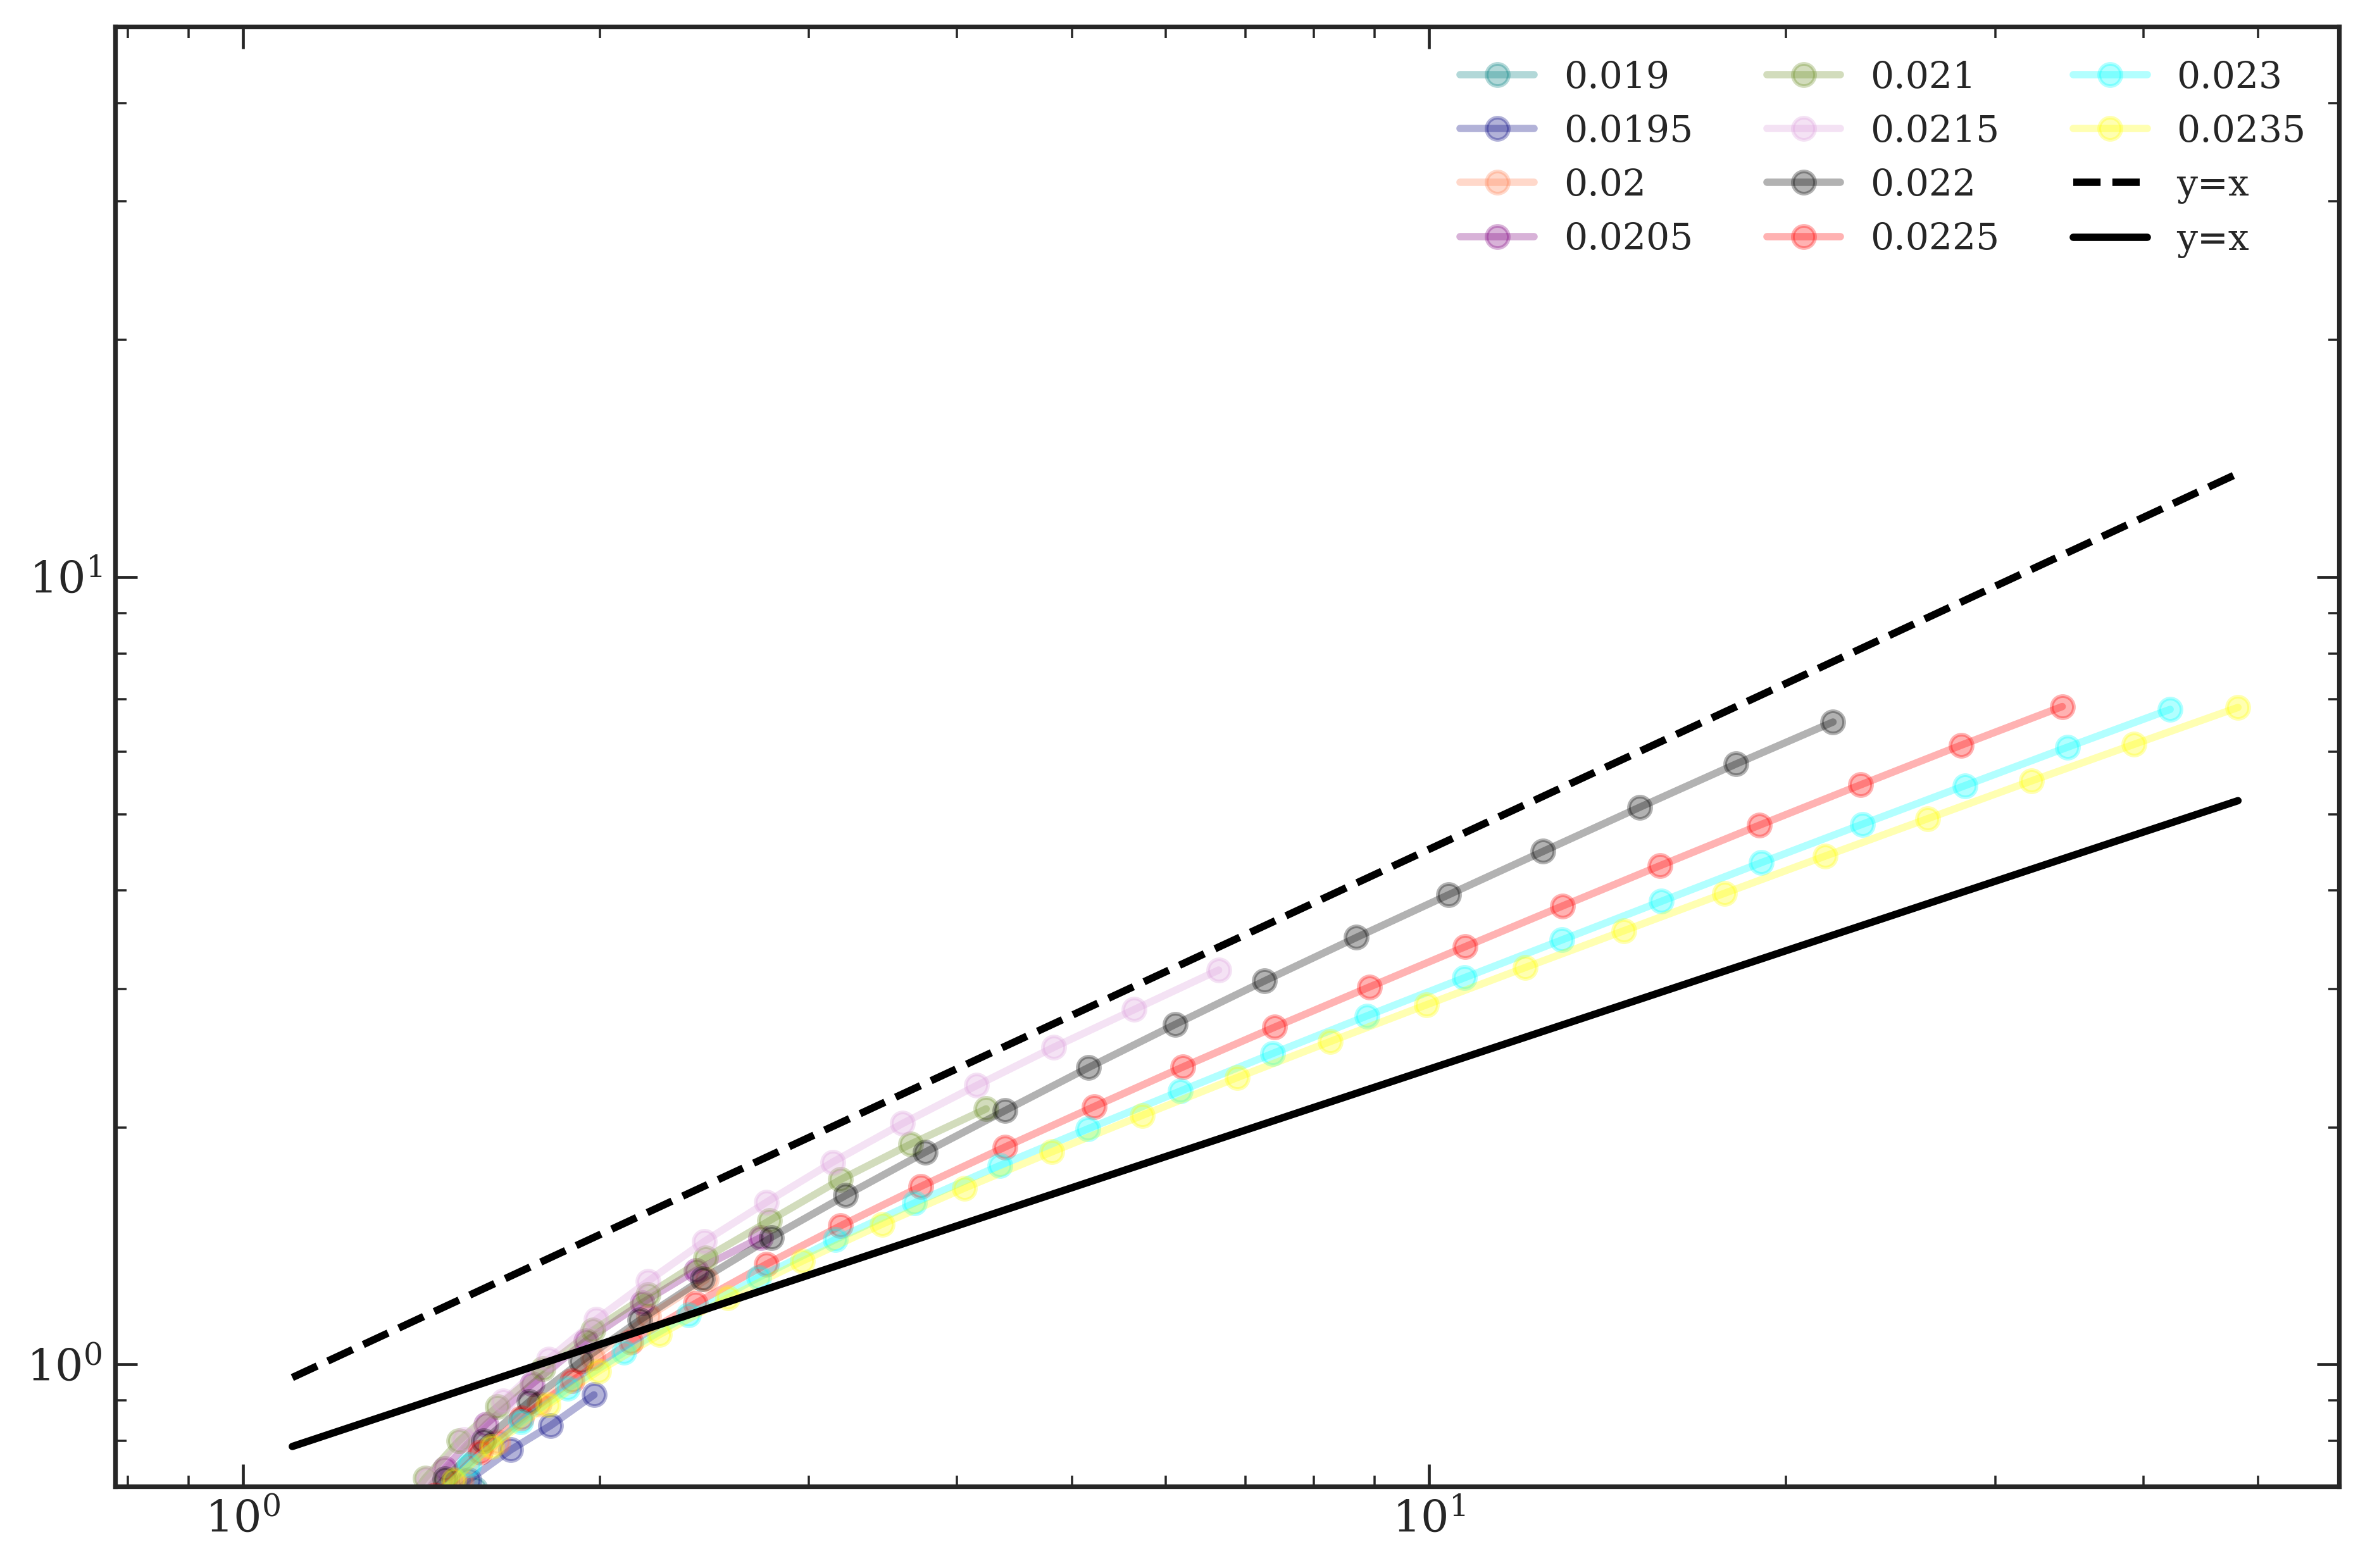

In [9]:
fig, ax = plt.subplots()
density=False
for i, act in enumerate(act_list[:10]):

    if density:
        ax.plot(av_dens[10:,i,0], np.sqrt(var_counts_norm[10:,i,0]), label=f'{act}', marker='.', alpha=.3)
    else:
        ax.plot(av_counts_av[:,i,0], np.sqrt(var_counts_av[:,i,0]), label=f'{act}', marker='o', alpha=.3)


ax.plot(av_counts_av[:,i,0], 0.9*av_counts_av[:,i,0]**0.7, label='y=x', color='black', linestyle='--')
ax.plot(av_counts_av[:,i,0], 0.75*av_counts_av[:,i,0]**0.5, label='y=x', color='black', linestyle='-')

ax.set_ylim(.7,50)
ax.legend(ncols=3,fontsize=10)
ax.set_xscale('log')
ax.set_yscale('log')

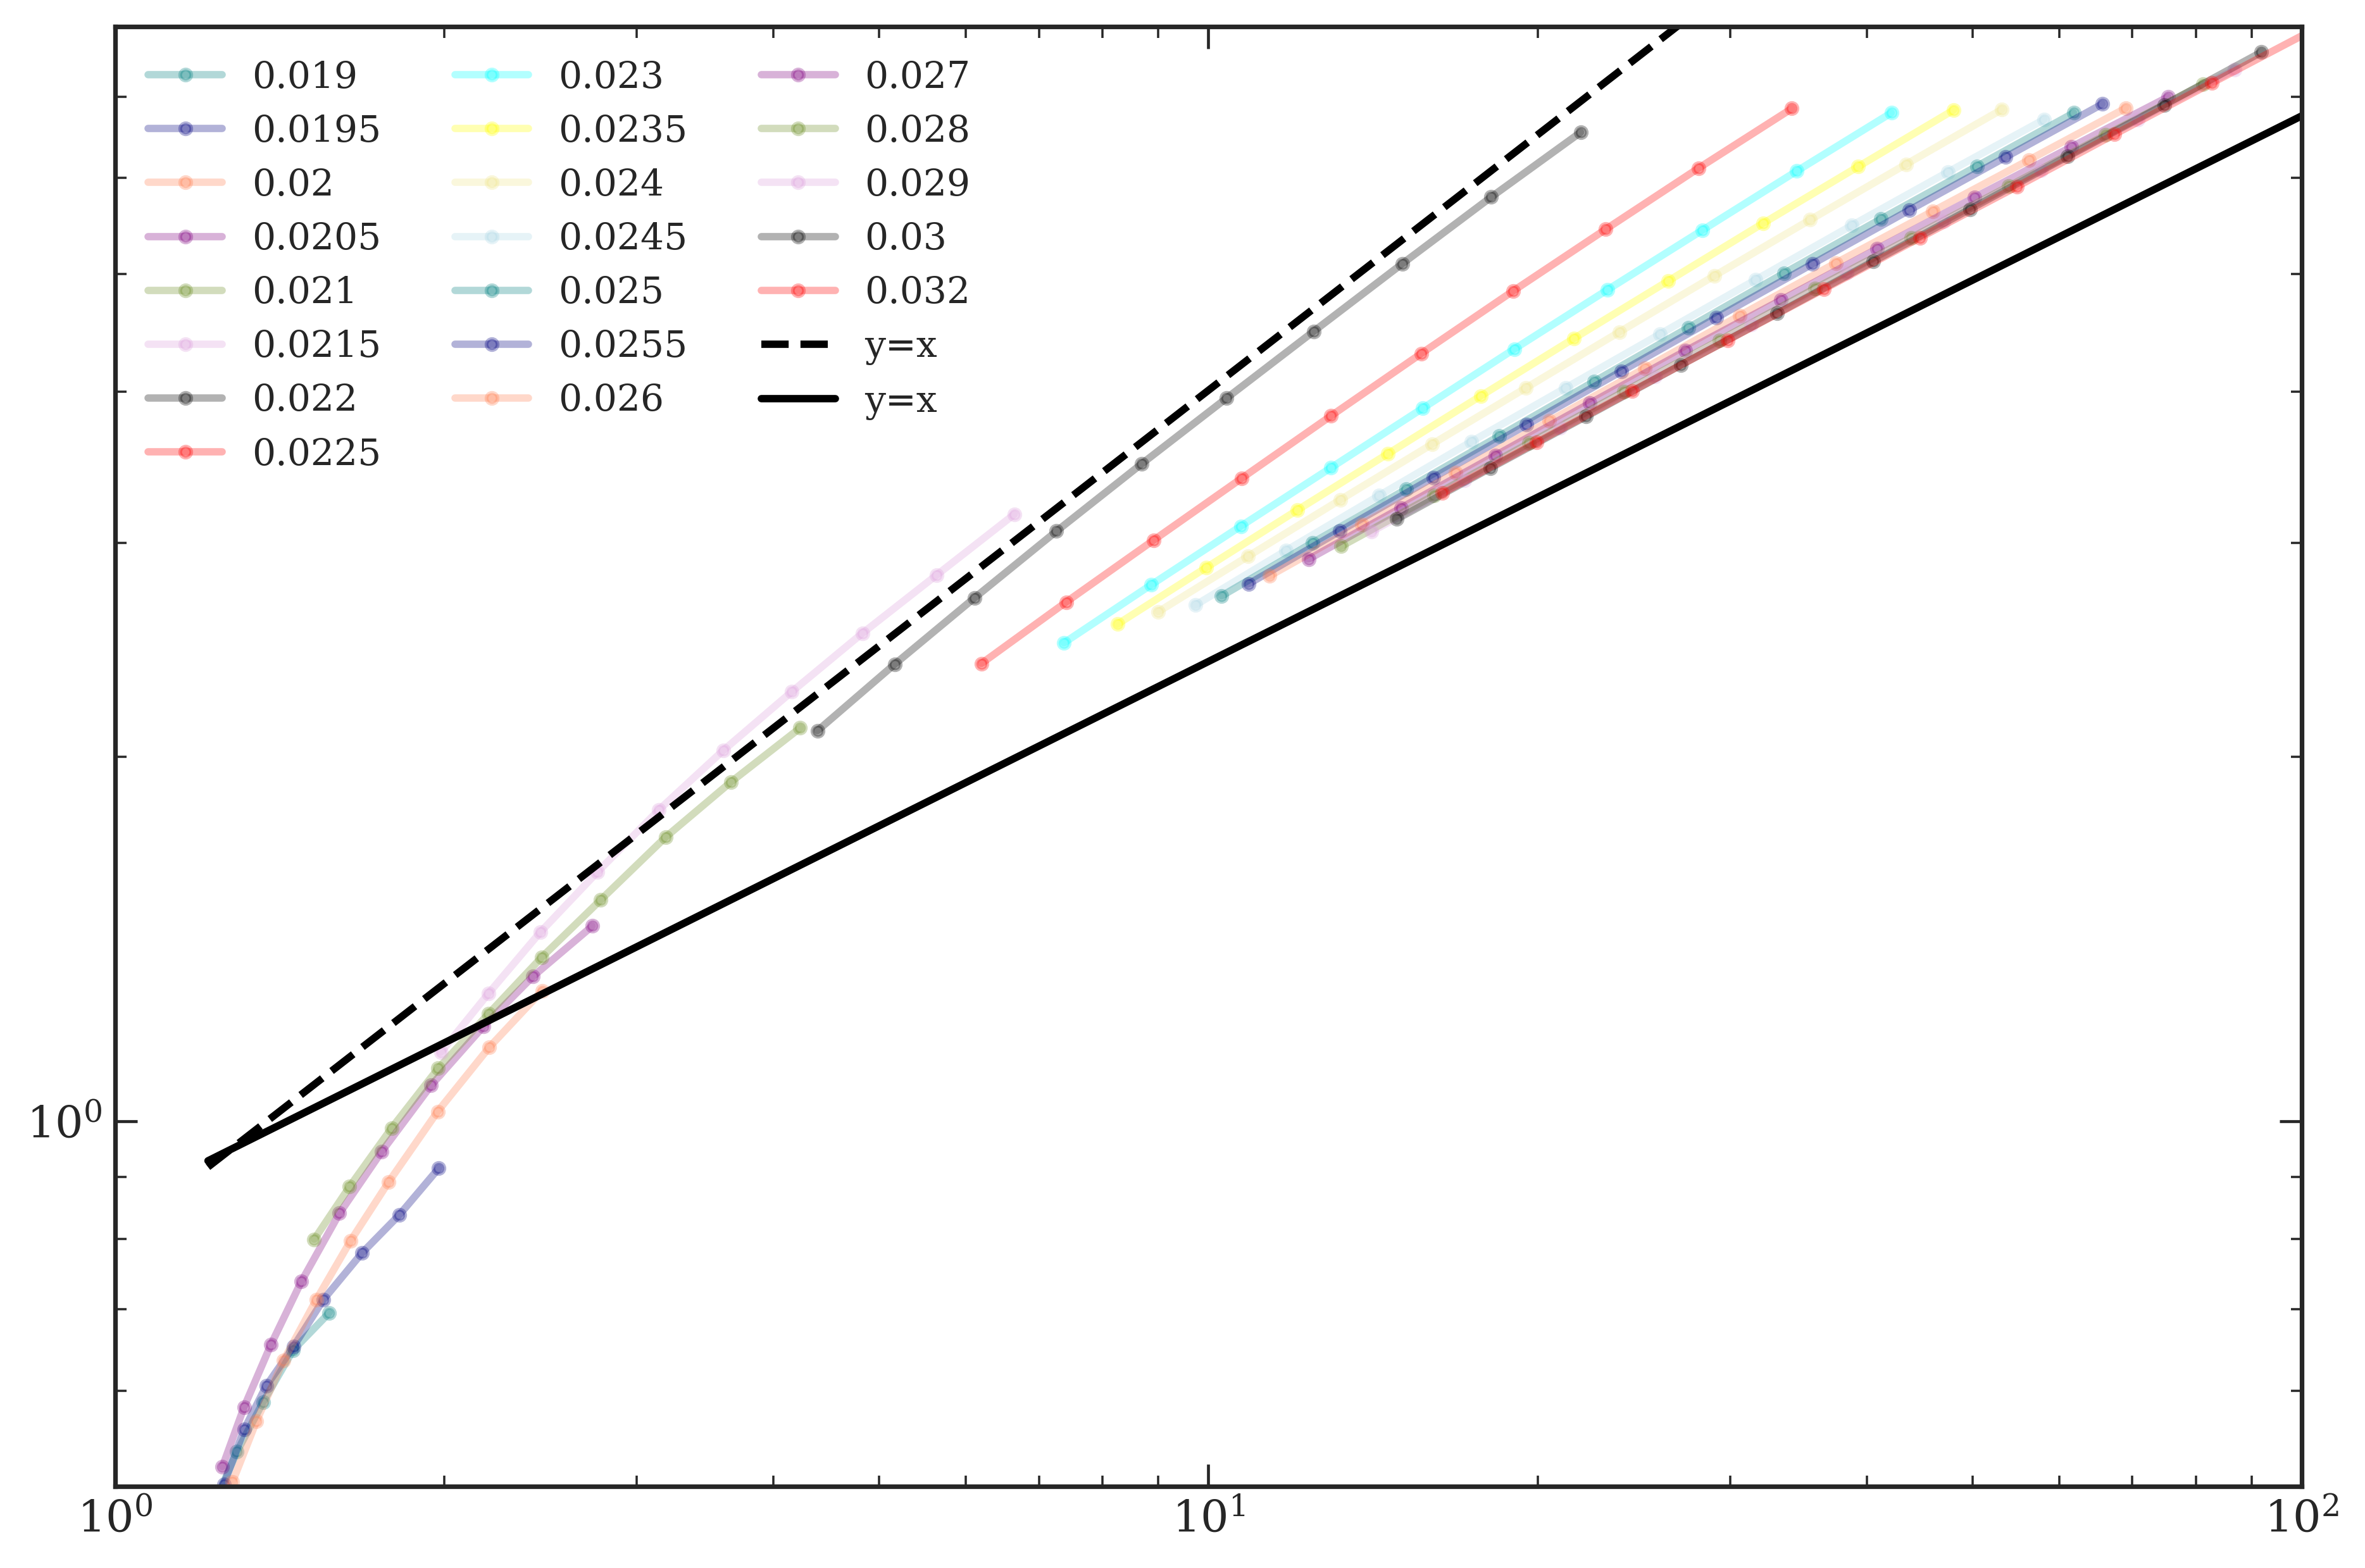

In [8]:
fig, ax = plt.subplots()
min_window_idx = 20
for i, act in enumerate(act_list[:20]):

    ax.plot(av_counts_av[min_window_idx:,i,0], np.sqrt(var_counts_av[min_window_idx:,i,0]), label=f'{act}', marker='.', alpha=.3)

ax.plot(av_counts_av[:,i,0], 0.8*av_counts_av[:,i,0]**0.7, label='y=x', color='black', linestyle='--')
ax.plot(av_counts_av[:,i,0], 0.85*av_counts_av[:,i,0]**0.45, label='y=x', color='black', linestyle='-')

ax.set_ylim(.5,8)
ax.set_xlim(1,100)
ax.legend(ncols=3,fontsize=10)
ax.set_xscale('log')
ax.set_yscale('log')


STEP 2: Using susceptibilities

In [11]:
system_size_list = [256, 512,1024, 2048]
#system_size_list = [2048]
ada = AnalyseDefectsAll(system_size_list)

from AnalyseDefectsAll import AnalyseDefectsAll as AnDef
adaa = AnDef(system_size_list)

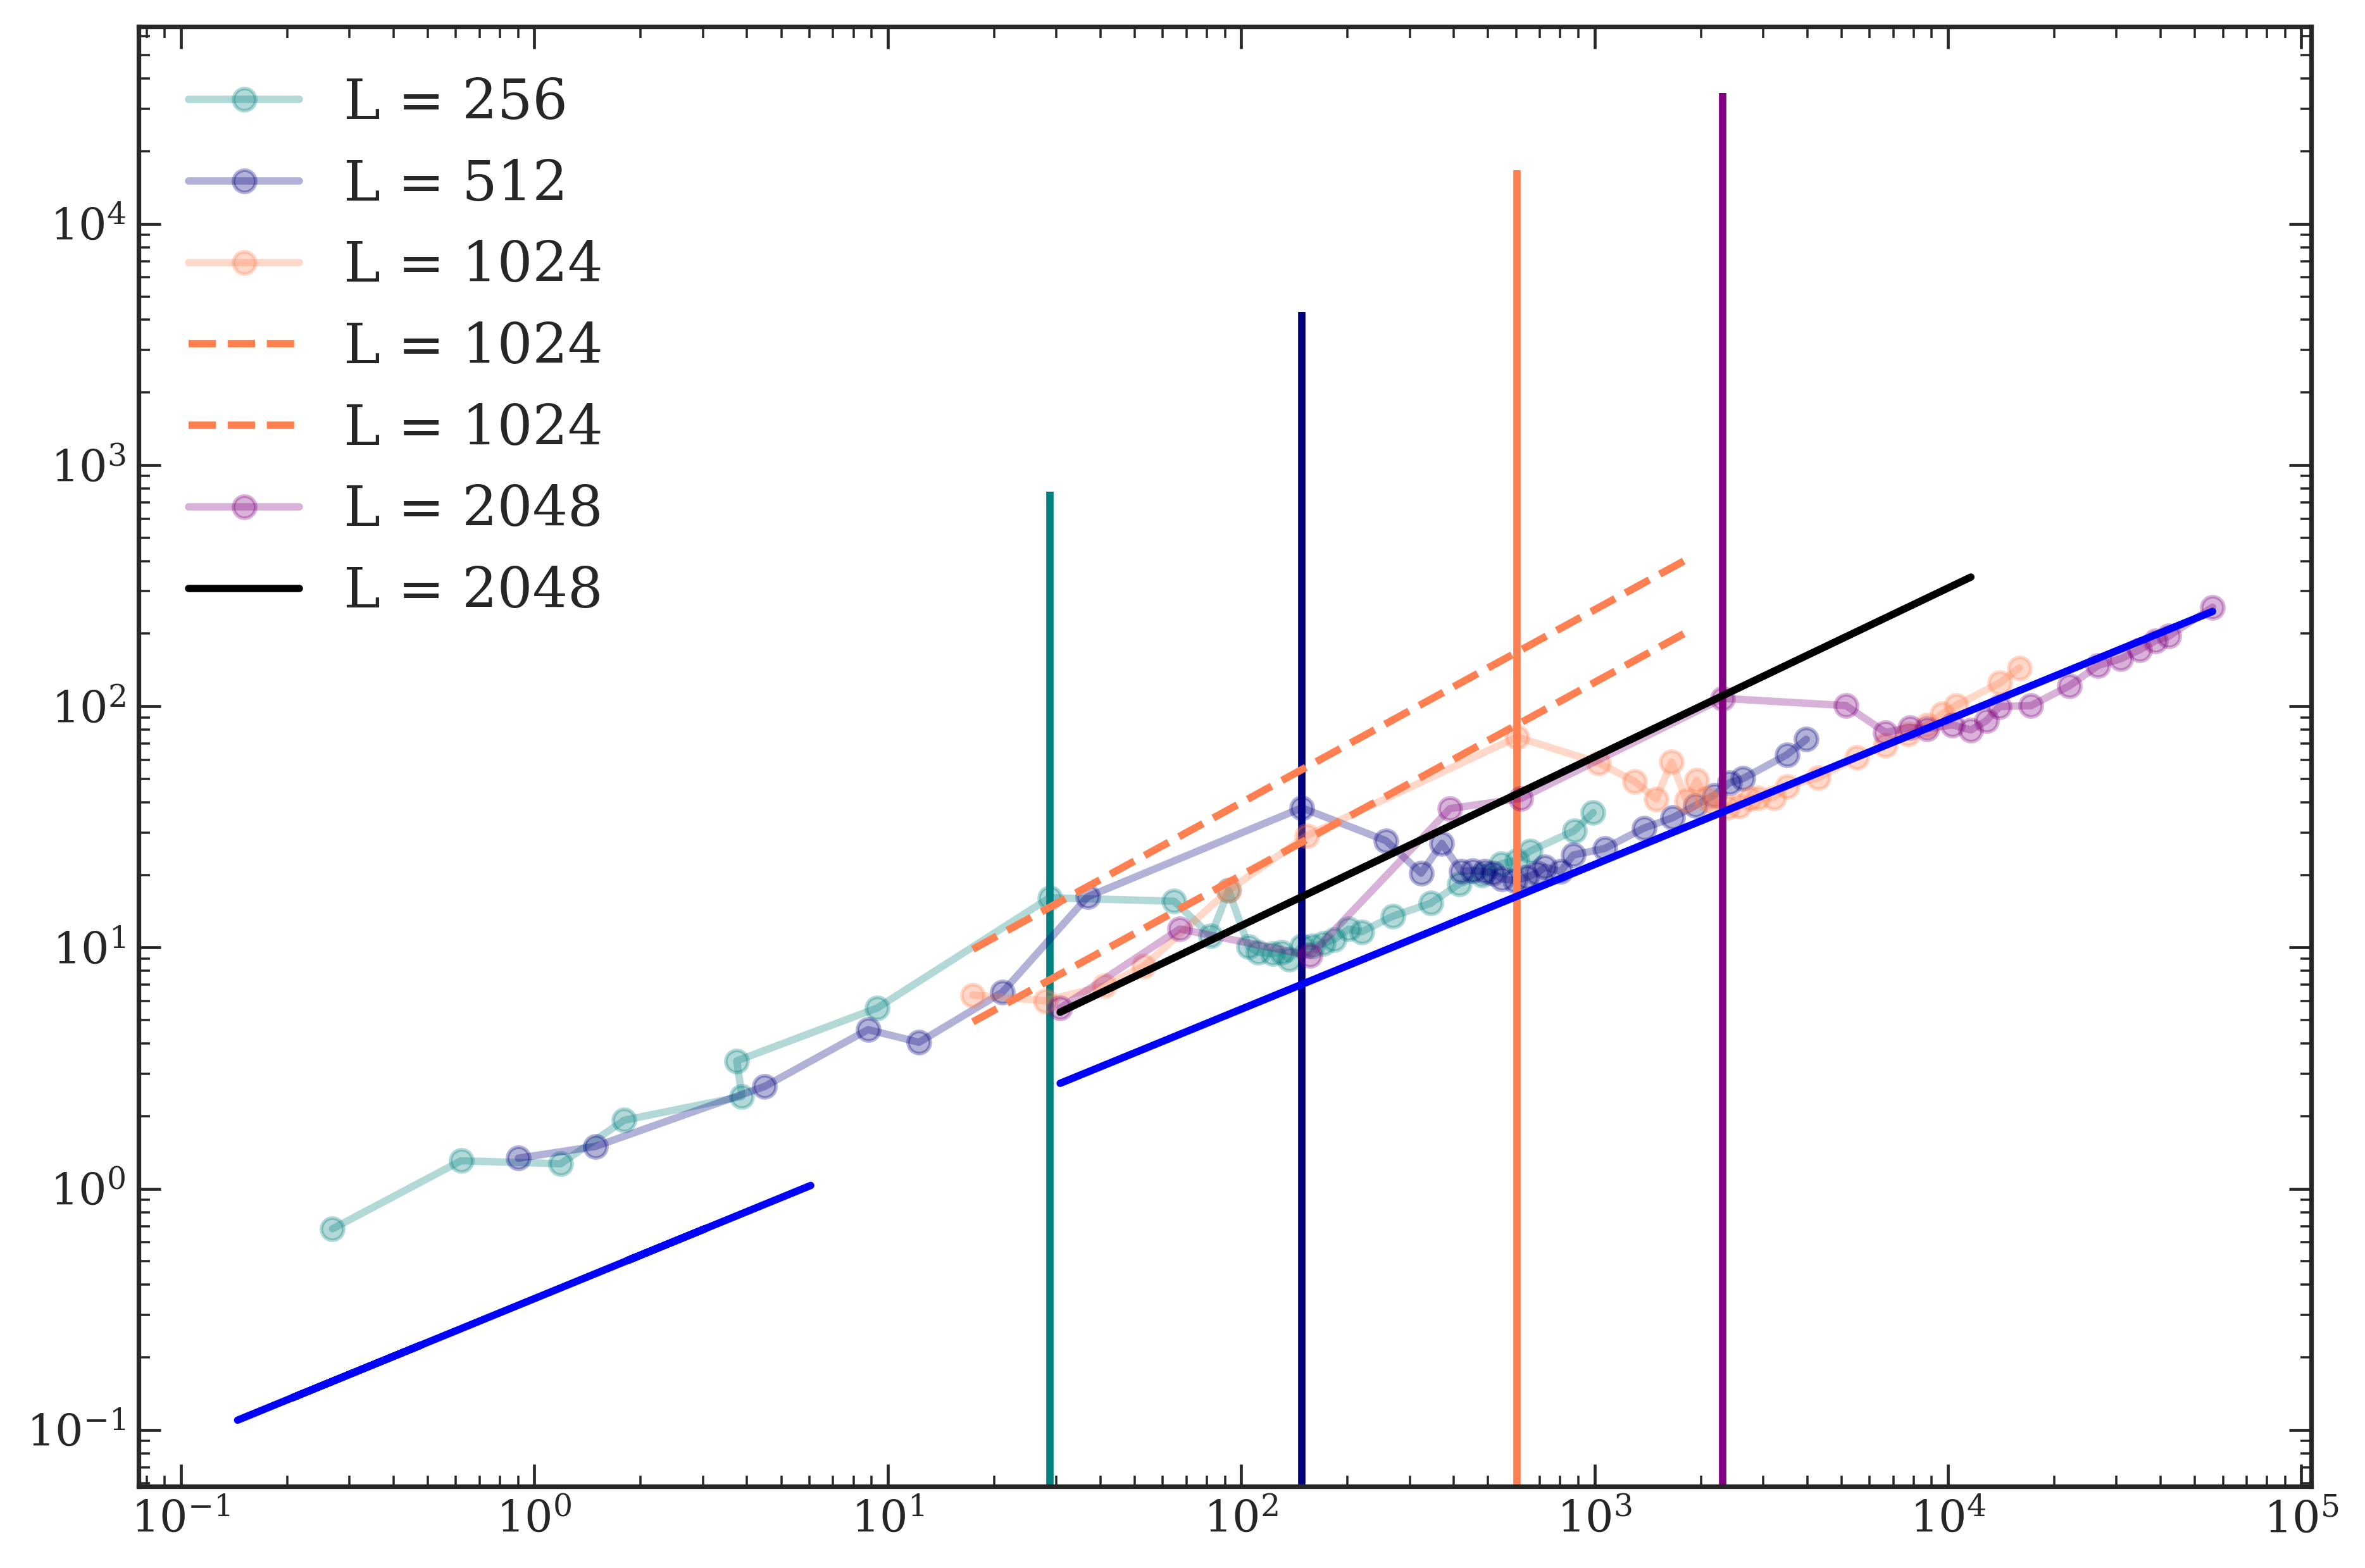

In [12]:
fig, ax = plt.subplots()

act = 0.022
density = False
for N, act_list in enumerate(ada.act_list):

    LX = ada.LX[N]
    act_idx = act_list.index(act)
    av_def = ada.get_av_defects(ada.LX[N], density = density)[1] #[act_idx,:]
    sus = ada.get_binder_susceptibility(ada.LX[N])[1]

    sus_scaled = sus[:,0] * av_def[:,0] #* LX**2
    sus_std = np.sqrt(sus_scaled)

    #ax.plot(av_def[:,0], sus[:,0] * av_def[:,0], 'o-', label = f'L = {ada.LX[N]}')
    ax.plot(av_def[:,0], sus_std, 'o-', label = f'L = {ada.LX[N]}', alpha=.3)
    ax.vlines(av_def[act_idx,0], 0, 3 * sus[act_idx,0] * av_def[act_idx,0],color = f'C{N}', linestyles='solid')
    
    a1 = np.max(np.diff(sus_scaled)[1] / np.diff(av_def[:,0])[1])
    if N == 2:
        ax.plot(av_def[:12,0],  1 * av_def[:12,0]**0.8, '--', color = f'C{N}', label = f'L = {ada.LX[N]}')
        ax.plot(av_def[:12,0],  .5 * av_def[:12,0]**0.8, '--', color = f'C{N}', label = f'L = {ada.LX[N]}')
   
    if N == 3:
        ax.plot(av_def[:12,0],  .49 * av_def[:12,0]**0.7, '-', color = f'black', label = f'L = {ada.LX[N]}')
        #ax.plot(av_def[:12,0],  1.7 * av_def[:12,0]**0.6, '-', color = f'k', label = f'L = {ada.LX[N]}')
        pass
        #ax.plot(av_def[10:,0], 0.6 * sus_std[10] + 8 * av_def[10:,0], '--', color = f'C{N}', label = f'L = {ada.LX[N]}')
  #  print(np.diff(sus_scaled)[0] / np.diff(av_def[:,0])[0])
ax.plot(av_def,.35*av_def**0.6, 'b-')
ax.set_xscale('log')    
ax.set_yscale('log')
ax.legend()